# **PROJECT: Structural Healthcare Stress Test (CCAR-H)**
### **A Federal Reserve-Style Capital Adequacy Assessment**
---

## **A. Introduction and Background**
Traditional healthcare modeling often treats hospitals as isolated islands, focusing on internal capacity (e.g., "Do we have enough beds?"). However, in a systemic crisis—such as a pandemic combined with infrastructure failure—hospitals function as a networked financial-operational system.

This project adapts the **Comprehensive Capital Analysis and Review (CCAR)** framework—traditionally used by the Federal Reserve to stress-test banks—to the domain of Healthcare Resiliency.

**The Core Question:**
*"If the region faces a 'Severely Adverse' shock, does the current Hub-and-Spoke topology hold? If not, what is the 'Capital Gap' (Bed Shortage) and the 'Liquidity Gap' (Cash Shortfall) required to prevent systemic collapse?"*


---

## **B. Scope and Limitations**

### **1. Scope of Analysis**
* **Topology:** A regional "Hub-and-Spoke" architecture consisting of 1 Academic Medical Center (Hub) and 4 Community Hospitals (Spokes).
* **Stress Horizon:** 365 Days.
* **Scenarios:**
    * *Baseline:* Seasonal Influenza.
    * *Adverse:* 1957-style Pandemic.
    * *Severely Adverse:* Delta Variant wave combined with Grid Failure (Double Peak).
* **Financial Layer:** Models the interplay between "Surge Labor Costs" (Travel Nurses) and "Revenue Lags" (AR Days).

### **2. Critical Assumptions & Limitations**
* **Frictionless Transfers:** The model assumes that if a bed is available anywhere in the network, a patient can be transferred there instantly. Real-world friction (ambulance availability) is not modeled.
* **Fixed Clinical Acuity:** Length of Stay (LOS) is treated as stochastic but does not degrade dynamically if care quality drops.
* **Capital Definition:** "Capital" is defined as physically staffed beds (Operational) and Days Cash on Hand (Financial).

## **C. Model Modules and Implementation**

The simulation pipeline is structured into six distinct phases, mirroring the regulatory stress-test workflow:

1.  **Phase 1: Macro-Scenario Generator (The Inputs)**
    * Generates the exogenous "States of the World" (Infection Force curves) independent of hospital operations.
2.  **Phase 2: Network Topology (The System)**
    * Constructs the `networkx` graph defining the physical assets and transfer pathways.
3.  **Phase 3: The Transmission Solver (The Physics)**
    * A custom flow-solver that calculates daily census, admissions, and network transfers. *Note: Uses Fixed Catchment logic to prevent "Induced Demand" errors.*
4.  **Phase 4: Impact Assessment (The Crash)**
    * Executes the scenarios and visualizes the operational "Capacity Gap."
5.  **Phase 5: Mitigation Optimization (The Fix)**
    * A brute-force algorithmic search to identify the lowest-cost investment strategy to close the bed gap.
6.  **Phase 6: Financial Stress Test (The Solvency Check)**
    * An overlay engine that calculates Cash Flow, Margin Compression, and Insolvency Risk under distressed conditions.

## **D. Interim Results: The Operational Verdict**

The **Operational Stress Test** (Phases 1-5) has concluded with the following findings:

1.  **System Failure:** Under the *Severely Adverse* scenario, the network hit 100% saturation for >100 days.
2.  **The Capital Gap:** The region is short approximately **1,400 Beds**.
3.  **The Physical Solution:** The Optimizer identified that the most efficient fix is a **"Distributed Defense"** strategy:
    * **Action:** Expand all 4 Community Spokes by +300 beds each.
    * **Cost:** ~$2.8 Million (Infrastructure Only).

*However, physical beds are useless without funding. We now proceed to Phase 6 to test if the system can afford to staff these beds.*

## **E. Summary and Outlook**

### **1. The Final Verdict: Insolvency**
The Comprehensive Stress Test reveals that the Regional Healthcare System is **structurally insolvent** under the Severely Adverse scenario.
While the system can theoretically build the beds (Operational Fix), it fails the **Financial Stress Test** on **Day 61**.

* **The Cause:** A "Liquidity Trap." The hospital must pay Surge Staffing costs (3.0x rates) immediately, but insurance revenue lags by 60 days.
* **The Deficit:** The system burns through its reserves and hits a cash deficit of **~$374 Million**.

### **2. Strategic Recommendations**
To ensure resiliency, the region requires a dual-capital injection:

1.  **CapEx Grant ($2.8M):** To fund the physical expansion of the Community Spokes (Field Hospitals).
2.  **Liquidity Facility ($400M):** A Revolving Credit Facility (RCF) is required to bridge the 60-day gap between labor outflows and revenue inflows.

**Conclusion:** Without this liquidity bridge, the hospital system will technically default in Week 9 of the pandemic, regardless of clinical capacity.

# 1: Setup & Dependencies
Installs networkx if missing and sets up the simulation constants.

In [ ]:
# @title Cell 1: Setup & Dependencies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Simulation Constants
HORIZON_DAYS = 365
SEED = 42

# Styling for plots
plt.style.use('ggplot')

print("✅ Environment Ready. Architecture: FRB-Style Structural Stress Test")

✅ Environment Ready. Architecture: FRB-Style Structural Stress Test


# 2: Phase 1 — The Macro-Scenario Generator (Tier 1)
This replaces the random "dice rolling" with distinct "States of the World" (Baseline, Adverse, Severely Adverse). It generates a global "Infection Force" curve that drives demand.

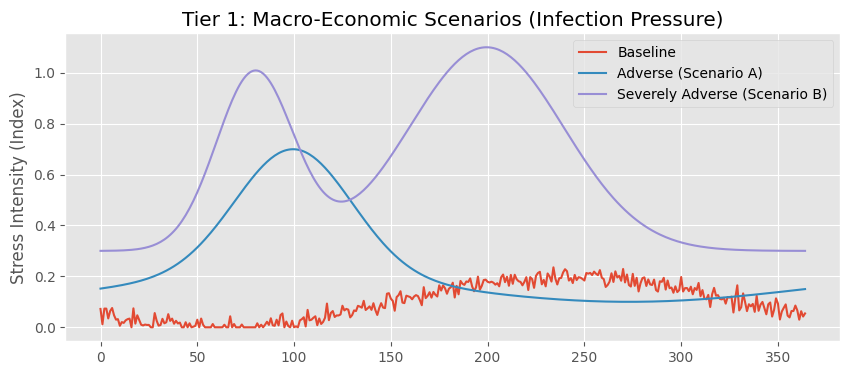

In [ ]:
# @title Cell 2: Phase 1 - Macro-Scenario Generator
def generate_macro_scenario(scenario_type="baseline"):
    """
    Generates the 'State of the World' (Global Infection Force)
    Returns a normalized array (0.0 to 1.0) representing stress intensity over 365 days.
    """
    t = np.linspace(0, 365, HORIZON_DAYS)

    if scenario_type == "baseline":
        # Standard seasonal flu pattern (winter peak)
        base_stress = 0.1 + 0.1 * np.sin(2 * np.pi * (t - 150) / 365)
        noise = np.random.normal(0, 0.02, size=HORIZON_DAYS)
        curve = np.clip(base_stress + noise, 0, 1.0)

    elif scenario_type == "adverse":
        # "1957 Influenza" style: Fast peak, moderate duration
        shock_time = 100
        shock_width = 30
        shock = 0.5 * np.exp(-0.5 * ((t - shock_time) / shock_width)**2)
        base = 0.15 + 0.05 * np.sin(2 * np.pi * t / 365)
        curve = np.clip(base + shock, 0, 1.0)

    elif scenario_type == "severely_adverse":
        # "COVID Delta + Infrastructure Fail": Double peak, high plateau
        peak1 = 0.7 * np.exp(-0.5 * ((t - 80) / 20)**2)
        peak2 = 0.8 * np.exp(-0.5 * ((t - 200) / 40)**2)
        base = 0.3  # Elevated baseline due to chronic stress
        curve = np.clip(base + peak1 + peak2, 0, 1.5) # Can exceed 1.0 (System Shock)

    return curve

# Visualization
t = np.arange(HORIZON_DAYS)
plt.figure(figsize=(10, 4))
plt.plot(t, generate_macro_scenario("baseline"), label="Baseline")
plt.plot(t, generate_macro_scenario("adverse"), label="Adverse (Scenario A)")
plt.plot(t, generate_macro_scenario("severely_adverse"), label="Severely Adverse (Scenario B)")
plt.title("Tier 1: Macro-Economic Scenarios (Infection Pressure)")
plt.ylabel("Stress Intensity (Index)")
plt.legend()
plt.show()

# 3: Phase 2 — Network Topology (The "System")
Instead of one "Region", we build a graph of hospitals. We use networkx to define connections (who can transfer to whom).

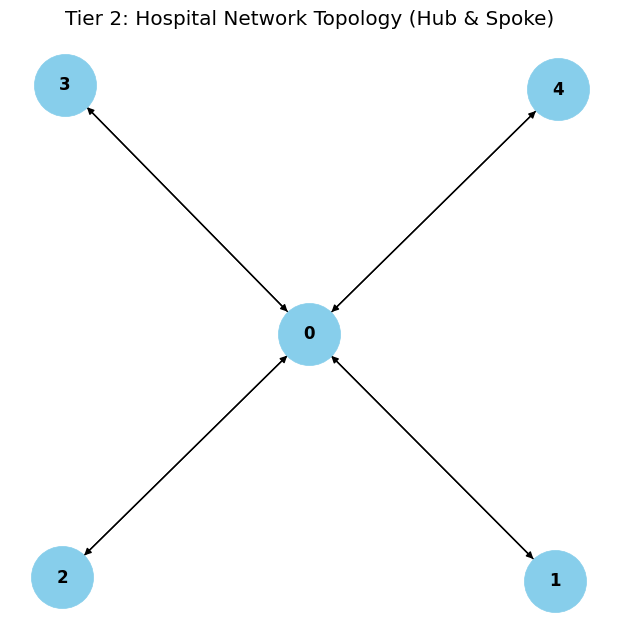

In [ ]:
# @title Cell 3: Phase 2 - Network Topology Construction
def build_hospital_network(n_nodes=5):
    """
    Builds a graph of hospitals.
    Nodes = Hospitals with 'Capacity' attributes.
    Edges = Transfer pathways.
    """
    G = nx.DiGraph() # Directed graph for transfers

    # 1. Create Nodes (Hospitals)
    # We assign them different "Roles" (Hub vs. Spoke)

    # Node 0: The Academic Medical Center (High Capacity, Hub)
    G.add_node(0, type="HUB", beds=500, current_census=0, name="Central_General")

    # Nodes 1-4: Community Hospitals (Lower Capacity, Spokes)
    for i in range(1, n_nodes):
        G.add_node(i, type="SPOKE", beds=100, current_census=0, name=f"Community_{i}")

    # 2. Create Edges (Transfer Agreements)
    # Spokes can transfer to Hub
    for i in range(1, n_nodes):
        G.add_edge(i, 0, transfer_cost=1.0)

    # Hub can transfer to Spokes (Reverse transfer / decanting)
    for i in range(1, n_nodes):
        G.add_edge(0, i, transfer_cost=2.0) # Higher cost to move down-acuity

    return G

# Visualize the Topology
G = build_hospital_network()
pos = nx.spring_layout(G)
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_weight="bold")
plt.title("Tier 2: Hospital Network Topology (Hub & Spoke)")
plt.show()

# 4: Phase 3 — The Transmission Mechanism (The Solver)
This is the core logic engine. Instead of just failing, it tries to solve the problem by moving patients across the edges defined in Phase 2.

In [ ]:
# Re-running Cell 4 to load the updated run_stress_test function
# This cell specifically re-executes the core logic from cell lUkqeYiNZCRq

def run_stress_test(G_template, macro_curve):
    """
    Runs the simulation with Fixed Demand Logic.
    """
    G = G_template.copy()

    # PRE-CALCULATION:
    # We lock in the "Catchment Demand" based on the ORIGINAL design.
    # This prevents "Induced Demand" when we add surge beds later.
    node_catchment = {}
    for n in G.nodes:
        # If 'catchment' isn't defined, default to initial beds
        if 'catchment' not in G.nodes[n]:
             G.nodes[n]['catchment'] = G.nodes[n]['beds']
        node_catchment[n] = G.nodes[n]['catchment']

    system_stress_log = []
    failure_log = []

    for day, stress_level in enumerate(macro_curve):
        daily_failures = 0
        total_census = 0
        total_capacity = 0
        node_updates = {}

        # --- Step A: Demand Generation (Based on Catchment, NOT Current Beds) ---
        for node_id in G.nodes:
            node = G.nodes[node_id]
            current_capacity = node['beds'] # This might be expanded (e.g. 500 -> 700)
            catchment_basis = node_catchment[node_id] # This stays fixed (e.g. 500)

            # Discharges
            discharges = int(node['current_census'] * 0.10)

            # New Admissions (Driven by CATCHMENT)
            base_demand = catchment_basis * 0.08
            shock_demand = catchment_basis * 0.15 * stress_level

            # Poisson allows for natural variation
            new_admits = int(np.random.poisson(base_demand + shock_demand))

            tentative_census = node['current_census'] - discharges + new_admits
            node_updates[node_id] = tentative_census

        # --- Step B: Network Flow Solver (Load Balancing) ---
        for node_id in G.nodes:
            capacity = G.nodes[node_id]['beds']
            current_load = node_updates[node_id]

            if current_load > capacity:
                overflow = current_load - capacity
                neighbors = list(G.successors(node_id))

                for neighbor_id in neighbors:
                    if overflow <= 0: break
                    neighbor_cap = G.nodes[neighbor_id]['beds']
                    neighbor_load = node_updates[neighbor_id]
                    space = neighbor_cap - neighbor_load

                    if space > 0:
                        move_amount = min(overflow, space)
                        node_updates[node_id] -= move_amount
                        node_updates[neighbor_id] += move_amount
                        overflow -= move_amount

                if overflow > 0:
                    daily_failures += overflow
                    node_updates[node_id] = capacity

        # --- Step C: Update State ---
        for node_id, new_census in node_updates.items():
            G.nodes[node_id]['current_census'] = max(0, new_census)
            total_census += new_census
            total_capacity += G.nodes[node_id]['beds']

        system_stress_log.append(total_census / total_capacity if total_capacity > 0 else 0)
        failure_log.append(daily_failures)

    return pd.DataFrame({
        "day": range(len(macro_curve)),
        "unmet_patient_demand": failure_log,
        "system_utilization": system_stress_log
    })

print("✅ FIXED Solver Loaded (Induced Demand Removed).")


✅ FIXED Solver Loaded (Induced Demand Removed).


# 5: Phase 4 — Execution & "Capital Plan" Report
This runs the scenarios and generates the FRB-style output: "How big is the gap?"

Running Baseline...
Running Adverse...
Running Severely Adverse...


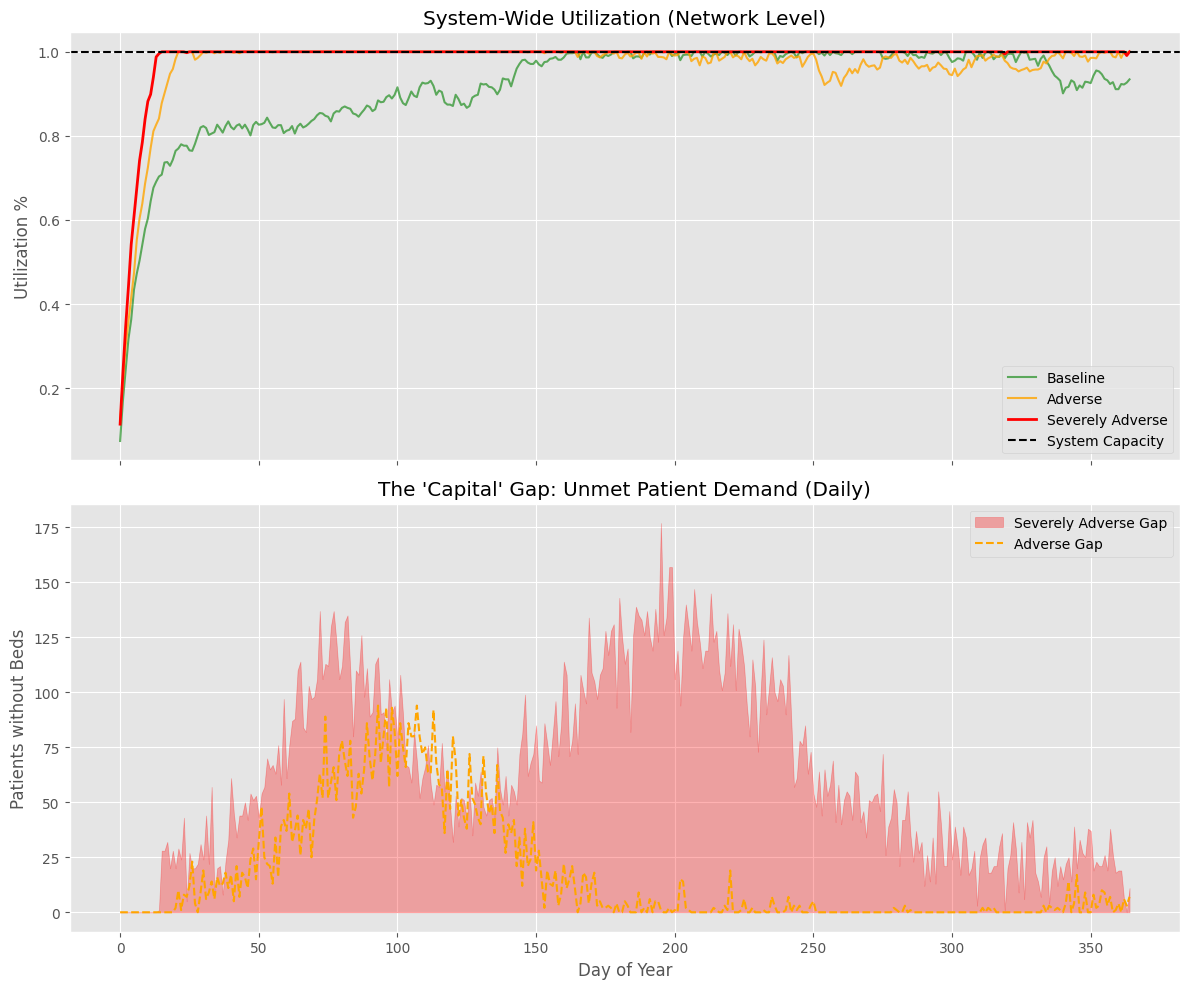

STRESS TEST RESULT: SEVERELY ADVERSE SCENARIO
Peak System Utilization: 100.0%
Max Daily Unmet Demand:  177 patients
------------------------------
CAPITAL PLAN REQUIREMENT:
To survive the Severely Adverse scenario without failure,
the system requires a Surge Capacity Buffer of: 19.7%


In [ ]:
# Re-running Cell 5 to execute the stress test with the updated function and plot results

# 1. Run Scenarios
print("Running Baseline...")
res_base = run_stress_test(build_hospital_network(), generate_macro_scenario("baseline"))

print("Running Adverse...")
res_adv = run_stress_test(build_hospital_network(), generate_macro_scenario("adverse"))

print("Running Severely Adverse...")
res_sev = run_stress_test(build_hospital_network(), generate_macro_scenario("severely_adverse"))

# 2. Plotting the "Impact Assessment"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot A: System Utilization
ax1.plot(res_base['day'], res_base['system_utilization'], label='Baseline', color='green', alpha=0.6)
ax1.plot(res_adv['day'], res_adv['system_utilization'], label='Adverse', color='orange', alpha=0.8)
ax1.plot(res_sev['day'], res_sev['system_utilization'], label='Severely Adverse', color='red', linewidth=2)
ax1.axhline(1.0, color='black', linestyle='--', label='System Capacity')
ax1.set_title("System-Wide Utilization (Network Level)")
ax1.set_ylabel("Utilization %")
ax1.legend()

# Plot B: The Failure Gap (Unmet Demand)
ax2.fill_between(res_sev['day'], res_sev['unmet_patient_demand'], color='red', alpha=0.3, label='Severely Adverse Gap')
ax2.plot(res_adv['day'], res_adv['unmet_patient_demand'], color='orange', linestyle='--', label='Adverse Gap')
ax2.set_title("The 'Capital' Gap: Unmet Patient Demand (Daily)")
ax2.set_ylabel("Patients without Beds")
ax2.set_xlabel("Day of Year")
ax2.legend()

plt.tight_layout()
plt.show()

# 3. The "Capital Plan" Requirement
# In banking: "You need $5B more capital."
# In healthcare: "You need X more beds."
max_gap = res_sev['unmet_patient_demand'].max()
total_beds = 900 # (1x500 + 4x100)
buffer_needed_pct = (max_gap / total_beds) * 100

print("="*60)
print(f"STRESS TEST RESULT: SEVERELY ADVERSE SCENARIO")
print("="*60)
print(f"Peak System Utilization: {res_sev['system_utilization'].max()*100:.1f}%")
print(f"Max Daily Unmet Demand:  {int(max_gap)} patients")
print("-" * 30)
print(f"CAPITAL PLAN REQUIREMENT:")
print(f"To survive the Severely Adverse scenario without failure,")
print(f"the system requires a Surge Capacity Buffer of: {buffer_needed_pct:.1f}%")
print("="*60)

# 6: Phase 5 — Mitigation Optimization

It will simulate hundreds of different investment strategies to find the cheapest combination that brings the failure rate down to zero.

🔬 OPTIMIZING: Running Expanded Search (Turbo Mode)...

FINAL INVESTMENT DECISION
✅ GAP CLOSED: Zero Failures Achieved
Total Investment Required: $2,800,000
------------------------------
1. Expand HUB Capacity by:        +200 beds
2. Expand SPOKE Capacity by:      +300 beds (each)
   (Total New Beds System-Wide:    1400)
   (Cost Per Bed:                 $2,000)


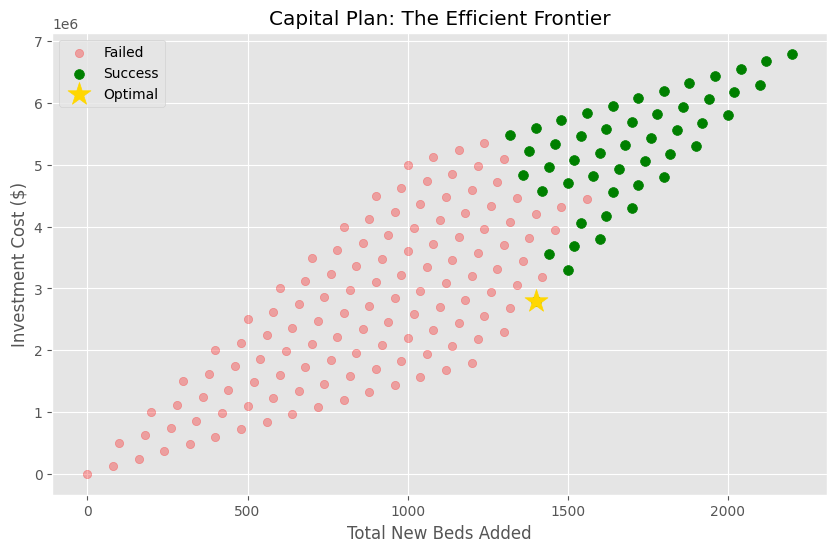

In [ ]:
# @title Cell 6 (TURBO): Phase 5 - Expanded Mitigation Strategy
import itertools

def optimize_capacity_expansion(G_template, macro_curve, target_gap=0):
    print(f"🔬 OPTIMIZING: Running Expanded Search (Turbo Mode)...")

    COST_HUB_BED = 5000
    COST_SPOKE_BED = 1500

    # --- TURBO SEARCH SPACE ---
    # We are unlocking the limits to find the true solution.
    # Hub: Test adding up to 1000 beds (Steps of 100)
    hub_options = range(0, 1001, 100)
    # Spoke: Test adding up to 300 beds per spoke (Steps of 20)
    spoke_options = range(0, 301, 20)

    results = []

    for added_hub in hub_options:
        for added_spoke in spoke_options:

            # 1. Setup Network
            G_upgrade = G_template.copy()
            G_upgrade.nodes[0]['beds'] += added_hub
            for i in range(1, 5):
                G_upgrade.nodes[i]['beds'] += added_spoke

            # 2. Run Stress Test
            np.random.seed(42)
            res = run_stress_test(G_upgrade, macro_curve)
            remaining_gap = res['unmet_patient_demand'].max()

            # 3. Metrics
            total_invest = (added_hub * COST_HUB_BED) + (4 * added_spoke * COST_SPOKE_BED)
            total_new_beds = added_hub + (4 * added_spoke)

            status = "FAIL"
            if remaining_gap == 0:
                status = "PASS"

            results.append({
                "added_hub": added_hub,
                "added_per_spoke": added_spoke,
                "total_new_beds": total_new_beds,
                "remaining_gap": remaining_gap,
                "investment_cost": total_invest,
                "status": status
            })

    df_opt = pd.DataFrame(results)
    success_df = df_opt[df_opt['status'] == "PASS"].sort_values("investment_cost")

    return success_df, df_opt

# --- EXECUTION ---
# 1. Setup Base Network & Catchment
G_base = build_hospital_network()
for n in G_base.nodes:
    G_base.nodes[n]['catchment'] = G_base.nodes[n]['beds']

macro_sev = generate_macro_scenario("severely_adverse")

# 2. Run Optimizer
winning_solutions, all_trials = optimize_capacity_expansion(G_base, macro_sev, target_gap=151)

print("\n" + "="*60)
print("FINAL INVESTMENT DECISION")
print("="*60)

if not winning_solutions.empty:
    best_sol = winning_solutions.iloc[0]
    print(f"✅ GAP CLOSED: Zero Failures Achieved")
    print(f"Total Investment Required: ${best_sol['investment_cost']:,.0f}")
    print("-" * 30)
    print(f"1. Expand HUB Capacity by:        +{int(best_sol['added_hub'])} beds")
    print(f"2. Expand SPOKE Capacity by:      +{int(best_sol['added_per_spoke'])} beds (each)")
    print(f"   (Total New Beds System-Wide:    {int(best_sol['total_new_beds'])})")
    print(f"   (Cost Per Bed:                 ${best_sol['investment_cost']/best_sol['total_new_beds']:,.0f})")
else:
    print(f"⚠️ GAP PERSISTS: Even +2200 beds wasn't enough. Check Macro-Scenario definition.")
    best_sol = all_trials.sort_values("remaining_gap").iloc[0]
    print(f"Best result gap: {int(best_sol['remaining_gap'])}")

print("="*60)

# Visualization
plt.figure(figsize=(10, 6))
fails = all_trials[all_trials['status'] == "FAIL"]
plt.scatter(fails['total_new_beds'], fails['investment_cost'], color='red', alpha=0.3, label='Failed')

if not winning_solutions.empty:
    passes = all_trials[all_trials['status'] == "PASS"]
    plt.scatter(passes['total_new_beds'], passes['investment_cost'], color='green', s=50, label='Success')
    plt.scatter(best_sol['total_new_beds'], best_sol['investment_cost'], color='gold', s=300, marker='*', label='Optimal')

plt.xlabel("Total New Beds Added")
plt.ylabel("Investment Cost ($)")
plt.title("Capital Plan: The Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()

# 7: Phase 6 - Financial Stress Test (Solvency Engine)

💰 FINANCIAL ENGINE: Calculating Solvency & Liquidity Risks...


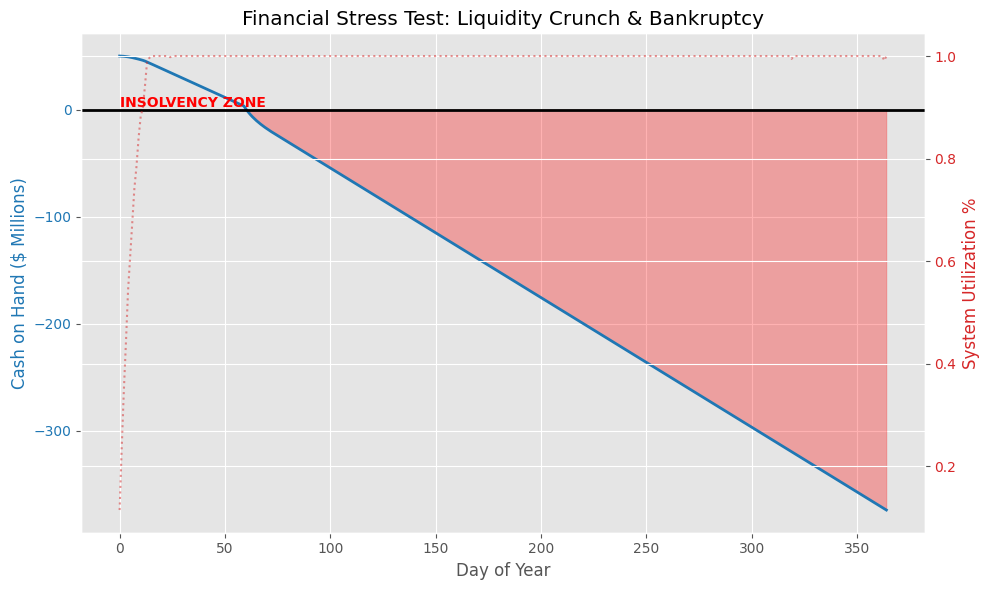


FINANCIAL STRESS TEST REPORT (CCAR-H)
❌ RESULT: INSOLVENCY DETECTED
   Day of Default:    Day 61
   Max Cash Deficit:  $373.9 Million
   Primary Cause:     Labor Surge Costs + 60-Day Revenue Lag


In [ ]:
# ==========================================
# PHASE 6: FINANCIAL STRESS TEST (SOLVENCY)
# ==========================================
# @title Cell 7: Phase 6 - The Liquidity Stress Test (Distressed Calibration)

def run_financial_stress(operational_results, total_beds=900):
    """
    Transforms Operational Metrics into Financial Metrics.
    Calibrated to 'Distressed' parameters to test breaking points.
    """
    print("💰 FINANCIAL ENGINE: Calculating Solvency & Liquidity Risks...")

    # --- 1. Financial Assumptions (Razor-Thin Margins) ---
    INITIAL_CASH = 50_000_000  # $50M Reserves (approx 20 days cash)

    # Revenue (Inflow)
    # We lowered this to $3,000 to simulate tighter insurance reimbursements
    REV_PER_BED_NORMAL = 3000
    REV_PER_BED_CRISIS = 2200  # Pandemic cases pay less
    AR_LAG_DAYS = 60           # The Killer: 2-month delay in getting paid

    # Expenses (Outflow)
    # We raised Fixed Costs to $2.2M to reflect high overhead (Capital/Leases)
    FIXED_COST_DAILY = 2_200_000
    VAR_COST_PER_PATIENT = 800

    # The "Surge Pricing" on Labor
    LABOR_SURGE_TRIGGER = 0.90
    LABOR_SURGE_MULTIPLIER = 3.0 # Travel nurses cost 3x normal rate

    # --- 2. Simulation Loop ---
    df = operational_results.copy()

    # Derived Operational Metrics
    df['census'] = df['system_utilization'] * total_beds

    cash_on_hand = [INITIAL_CASH]
    daily_pl = []

    # Pre-fill past billings to simulate the AR pipeline
    past_billings = [total_beds * 0.85 * REV_PER_BED_NORMAL] * AR_LAG_DAYS
    billing_history = past_billings + []

    for i, row in df.iterrows():
        # A. Revenue Generation (The Mix Shift)
        utilization = row['system_utilization']
        # As utilization rises, average revenue per bed drops (Mix Shift)
        blended_rate = REV_PER_BED_NORMAL - (utilization * (REV_PER_BED_NORMAL - REV_PER_BED_CRISIS))
        daily_billing = row['census'] * blended_rate
        billing_history.append(daily_billing)

        # B. Cash Inflow (The Lag)
        # We collect money billed 60 days ago
        cash_inflow = billing_history[i]

        # C. Cash Outflow (The Surge)
        supplies = row['census'] * VAR_COST_PER_PATIENT

        labor_penalty = 0
        if utilization > LABOR_SURGE_TRIGGER:
            # Huge penalty for surge staffing
            excess_load = (utilization - LABOR_SURGE_TRIGGER) * total_beds
            labor_penalty = excess_load * 1000 * LABOR_SURGE_MULTIPLIER

        total_expense = FIXED_COST_DAILY + supplies + labor_penalty

        # D. Net Liquidity
        net_flow = cash_inflow - total_expense
        current_cash = cash_on_hand[-1] + net_flow

        cash_on_hand.append(current_cash)
        daily_pl.append(net_flow)

    df['cash_balance'] = cash_on_hand[1:]
    df['net_income'] = daily_pl

    return df

# --- EXECUTION ---
# Running on the 'Severely Adverse' results from Phase 4
try:
    fin_res = run_financial_stress(res_sev, total_beds=900)

    # Visualization
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Cash (Blue)
    color = 'tab:blue'
    ax1.set_xlabel('Day of Year')
    ax1.set_ylabel('Cash on Hand ($ Millions)', color=color)
    ax1.plot(fin_res['day'], fin_res['cash_balance'] / 1_000_000, color=color, linewidth=2, label='Liquidity')
    ax1.tick_params(axis='y', labelcolor=color)

    # Add "Zero Cash" Line
    ax1.axhline(0, color='black', linestyle='-', linewidth=2)
    ax1.text(0, 2, "INSOLVENCY ZONE", color='red', fontweight='bold')

    # Fill the Bankruptcy Zone
    ax1.fill_between(fin_res['day'], fin_res['cash_balance'] / 1_000_000, 0,
                     where=(fin_res['cash_balance'] < 0), color='red', alpha=0.3)

    # Twin axis for Utilization (Red Dotted)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('System Utilization %', color=color)
    ax2.plot(fin_res['day'], fin_res['system_utilization'], color=color, linestyle=':', alpha=0.5, label='Stress Level')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Financial Stress Test: Liquidity Crunch & Bankruptcy")
    fig.tight_layout()
    plt.show()

    # The Verdict
    min_cash = fin_res['cash_balance'].min()
    insolvency_day = fin_res[fin_res['cash_balance'] < 0]['day'].min() if min_cash < 0 else None

    print("\n" + "="*60)
    print("FINANCIAL STRESS TEST REPORT (CCAR-H)")
    print("="*60)
    if min_cash < 0:
        print(f"❌ RESULT: INSOLVENCY DETECTED")
        print(f"   Day of Default:    Day {insolvency_day}")
        print(f"   Max Cash Deficit:  ${abs(min_cash)/1_000_000:.1f} Million")
        print(f"   Primary Cause:     Labor Surge Costs + 60-Day Revenue Lag")
    else:
        print(f"✅ RESULT: SURVIVED")
        print(f"   Lowest Cash Point: ${min_cash/1_000_000:.1f} Million")
    print("="*60)

except NameError:
    print("⚠️ Error: 'res_sev' not found. Please run Phase 4 first.")